<a href="https://colab.research.google.com/github/whuan349/DS3000_Credit_Card_Fraud_Detection/blob/master/DS3000_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS3000 Credit Card Fraud Detection

# Task 1 — Fraud Detection Motivation & Baseline Metrics

This Task:

*   Implements a trivial baseline classifier that predicts all transactions aS legitimate (Class = 0).

*   Computes key evaluation metrics (Accuracy, Precision, Recall, F1-Score) to establish a starting performance benchmark.

*   Demonstrates why accuracy alone is misleading for fraud detection by showing that minority-class metrics remain zero when no fraud cases are detected.
*   Highlights the necessity of using precision, recall, and F1-score to properly assess model performance on imbalanced classification tasks.

*   Provides a reference point against which all subsequent machine-learning models are compared.

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

In [26]:
# 1. Load and inspect the data
df = pd.read_csv("creditcard_2023.csv")

print(df.head())

   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   

        V26       V27       V28    Amount  C

In [27]:
print(df.columns)


Index(['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [28]:
# 2. Clean and prepare the Class column (target variable)
df = df.dropna(subset=["Class"])        # Drop any rows where the label (Class) is missing
df["Class"] = df["Class"].astype(int)   # Ensure the label is stored as integer 0/1

# Check distribution of the labels
print(df["Class"].value_counts())
print("\nClass distribution (proportion):")
print(df["Class"].value_counts(normalize=True))

Class
0    284315
1    284315
Name: count, dtype: int64

Class distribution (proportion):
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [29]:
# 3. Create baseline predictions
y_true = df["Class"].values
y_pred = np.zeros_like(y_true)

from sklearn.metrics import precision_score, recall_score, f1_score

# 4. Compute evaluation metrics
accuracy = (y_pred == y_true).mean()
precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

print("==== BASELINE MODEL RESULTS ====")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

==== BASELINE MODEL RESULTS ====
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Explanation of Zero Precision, Recall, and F1-Score

The baseline classifier was designed to predict all transactions as legitimate (Class = 0). As a result, the model never produced any predictions for the fraud class (Class = 1). Because no transactions were predicted as fraudulent, the number of true positives was zero.

Precision measures the proportion of predicted fraud cases that are actually fraud; since the baseline predicted zero fraud cases, precision is zero. Recall measures the proportion of actual fraud cases that were correctly identified; again, because no fraud cases were predicted, recall is zero. The F1-score, which is the harmonic mean of precision and recall, is also zero because both values are zero.

These results demonstrate that although the baseline classifier may achieve moderate or even high accuracy depending on class distribution, it completely fails to perform the primary task of interest—detecting fraudulent transactions—highlighting the need for more advanced machine learning models and more appropriate evaluation metrics.

# Task 2 — Data Understanding & Preprocessing Framework

This Task:
- Describes the credit card fraud dataset (size, PCA components, class imbalance).  
- Implements the preprocessing pipeline (stratified 80/10/10 split, Min–Max scaling on Amount, SMOTE).  
- Shows class distribution before and after SMOTE.
- Uses Preprocess.py to calculate the split and SMOTE.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


from preprocess import load_and_preprocess_data



## 1. Load raw dataset


In [31]:
# Load just the raw dataframe for description
df_raw = pd.read_csv("creditcard_2023.csv")

print("Dataset shape:", df_raw.shape)
print("\nFirst few rows:")
print(df_raw.head())

Dataset shape: (568630, 31)

First few rows:
   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   


## 2. Class distribution (raw data)

Class counts (raw data):
Class
0    284315
1    284315
Name: count, dtype: int64


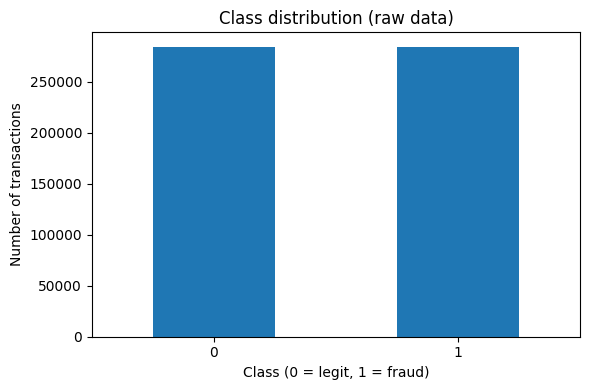


Minority / majority ratio: 1.000000


In [32]:
label_col = "Class"  # adjust here if your label name ever changes

class_counts = df_raw[label_col].value_counts().sort_index()
print("Class counts (raw data):")
print(class_counts)

plt.figure(figsize=(6, 4))
class_counts.plot(kind="bar")
plt.title("Class distribution (raw data)")
plt.xlabel(f"{label_col} (0 = legit, 1 = fraud)")
plt.ylabel("Number of transactions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

minority_ratio = class_counts.min() / class_counts.max()
print(f"\nMinority / majority ratio: {minority_ratio:.6f}")


## 3. Run Full Preprocessing Pipeline (Split, Scale, SMOTE)


In [33]:
data = load_and_preprocess_data("creditcard_2023.csv")

X_train = data["X_train"]
X_val   = data["X_val"]
X_test  = data["X_test"]
y_train = data["y_train"]
y_val   = data["y_val"]
y_test  = data["y_test"]

X_train_sm = data["X_train_sm"]   # after SMOTE
y_train_sm = data["y_train_sm"]

print("Train shape (before SMOTE):", X_train.shape)
print("Train labels (before SMOTE):", y_train.value_counts().to_dict())
print("\nTrain shape (after SMOTE):", X_train_sm.shape)
print("Train labels (after SMOTE):", Counter(y_train_sm))
print("\nVal shape:", X_val.shape, " Labels:", y_val.value_counts().to_dict())
print("Test shape:", X_test.shape, " Labels:", y_test.value_counts().to_dict())


Train shape (before SMOTE): (454904, 29)
Train labels (before SMOTE): {0: 227452, 1: 227452}

Train shape (after SMOTE): (454904, 29)
Train labels (after SMOTE): Counter({0: 227452, 1: 227452})

Val shape: (56863, 29)  Labels: {1: 28432, 0: 28431}
Test shape: (56863, 29)  Labels: {0: 28432, 1: 28431}


SMOTE does not change the dataset in our case because the original training data is already perfectly balanced (equal number of class 0 and class 1 samples). SMOTE can only oversample when a minority class exists. Since there is no imbalance, the training size and class distribution remain identical before and after SMOTE, meaning SMOTE provides no benefit for this dataset.

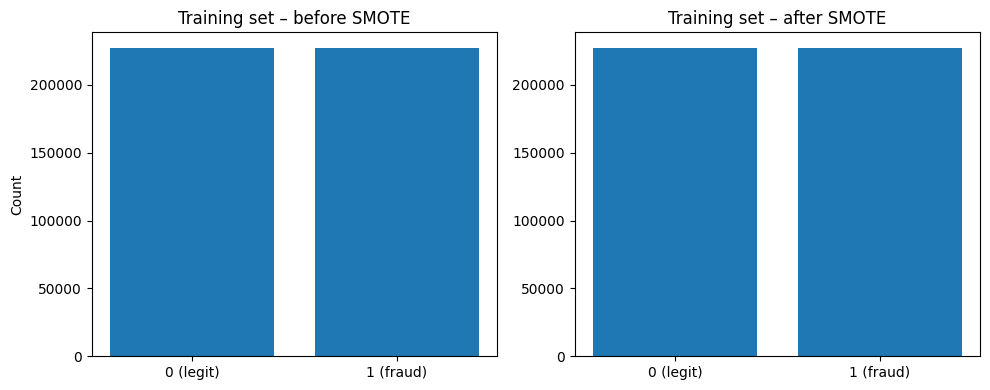

In [34]:
plt.figure(figsize=(10, 4))

# Before SMOTE
plt.subplot(1, 2, 1)
counts_before = y_train.value_counts().sort_index()
plt.bar(counts_before.index, counts_before.values)
plt.title("Training set – before SMOTE")
plt.xticks([0, 1], ["0 (legit)", "1 (fraud)"])
plt.ylabel("Count")

# After SMOTE
plt.subplot(1, 2, 2)
counts_after = Counter(y_train_sm)
plt.bar(counts_after.keys(), counts_after.values())
plt.title("Training set – after SMOTE")
plt.xticks([0, 1], ["0 (legit)", "1 (fraud)"])

plt.tight_layout()
plt.show()


- SMOTE did not change the training data because our dataset is already perfectly balanced, both classes (0 = legit, 1 = fraud) have the exact same number of samples.

- SMOTE only generates new synthetic samples when there is a minority class. Since both classes are equal in size, there is nothing to oversample.

- As a result, the class counts and shapes of the training set remain identical before and after SMOTE, which is exactly what we observe in the plots above.

## 4. Check Amount scaling

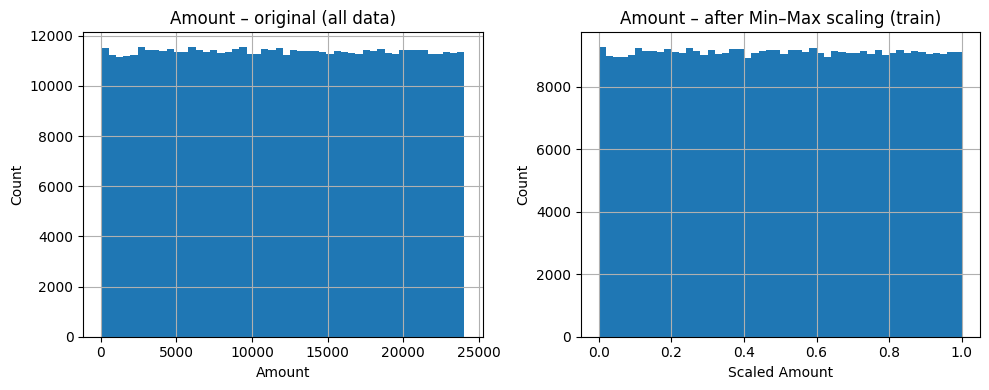

In [35]:
# Compare Amount before vs after scaling (on training set)
if "Amount" in df_raw.columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    df_raw["Amount"].hist(bins=50)
    plt.title("Amount – original (all data)")
    plt.xlabel("Amount")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    # X_train is a DataFrame with scaled Amount
    X_train["Amount"].hist(bins=50)
    plt.title("Amount – after Min–Max scaling (train)")
    plt.xlabel("Scaled Amount")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()


The Amount column has a very large numerical range, which can dominate model training. Min–Max scaling rescales it to [0,1] while keeping the overall distribution the same.

This ensures the feature contributes proportionally and improves model stability and performance.

# Task 3 — Model Implementation & Training

This Task:
- Implements three machine learning models for fraud detection:
  - Logistic Regression
  - Random Forest
  - XGBoost
- Uses the preprocessed and SMOTE-balanced training data generated in Task 2.
- Trains each model and measures:
  - Training time
  - Validation prediction time
  - Test prediction time
- Imports and executes the full training pipeline from `train_models.py`.
- Returns all trained models and timing metrics for use in Task 4, where model performance comparisons will be performed.


In [36]:
from train_models import train_all_models

In [37]:
results = train_all_models("creditcard_2023.csv")
results

Loading dataset and applying preprocessing...
Preprocessing complete.

Training Logistic Regression...
Logistic Regression trained. (Time: 1.14 sec)

Training Random Forest...
Random Forest trained. (Time: 46.02 sec)

Training XGBoost...
XGBoost trained. (Time: 6.00 sec)

Measuring prediction times...
Prediction timing complete.

All models trained and timed successfully!


{'log_reg': LogisticRegression(class_weight='balanced', max_iter=500),
 'random_forest': RandomForestClassifier(class_weight='balanced', max_depth=12,
                        min_samples_leaf=3, min_samples_split=5, n_jobs=-1,
                        random_state=42),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estima

The output confirms that all three models: Logistic Regression, Random Forest, and XGBoost, were successfully trained using the SMOTE-balanced dataset. Logistic Regression acts like a simple linear baseline, while Random Forest and XGBoost are more complex tree-based models that are capable of learning non-linear patterns. The printed objects show their configurations, showing that they are prepared for evaluation in Task 4, where we will compare how well each model detects fraud.

In [38]:
import pandas as pd

pd.DataFrame(results["timing"]).T

,train_time,val_pred_time,test_pred_time
logistic_regression,1.137597,0.017331,0.014866
random_forest,46.015550,0.089688,0.070266
xgboost,5.996542,0.082978,0.048939


The timing table shows clear differences in computational cost between the models. Logistic Regression trains and predicts the fastest because it is the most simple. Random Forest has the slowest training time since it builds many decision trees, but still predicts quickly. XGBoost has a good balance, training much faster than Random Forest while maintaining efficient prediction times. These results show each model’s efficiency and will help inform which is most practical and effective when combined with accuracy metrics in Task 4.

# Task 4 — Experimental Evaluation & Comparative Analysis

Loading dataset and applying preprocessing...
Preprocessing complete.

Training Logistic Regression...
Logistic Regression trained. (Time: 1.13 sec)

Training Random Forest...
Random Forest trained. (Time: 46.01 sec)

Training XGBoost...
XGBoost trained. (Time: 6.31 sec)

Measuring prediction times...
Prediction timing complete.

All models trained and timed successfully!
Confusion Matrix — Logistic Regression
[[27787   645]
 [ 1338 27093]] 



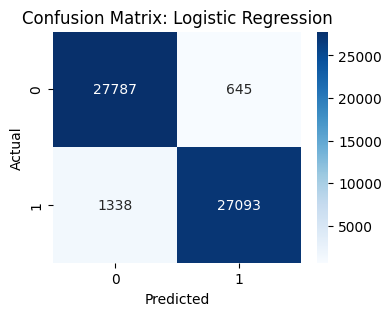

Confusion Matrix — Random Forest
[[28398    34]
 [  307 28124]] 



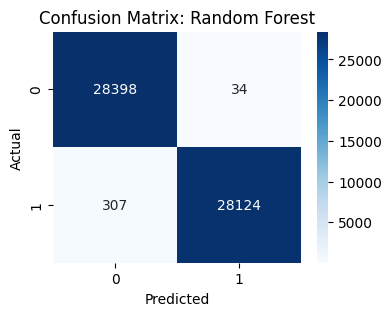

Confusion Matrix — XGBoost
[[28385    47]
 [    0 28431]] 



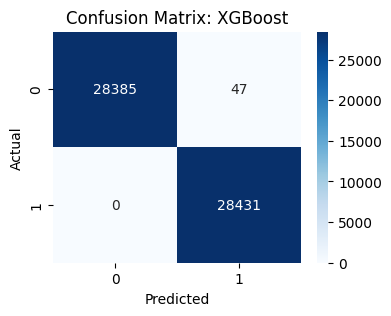

Model Performance Overview:

                     Precision    Recall  F1-score   AUC-ROC  Accuracy  \
Logistic Regression   0.976747  0.952939  0.964696  0.993399  0.965127   
Random Forest         0.998793  0.989202  0.993974  0.999884  0.994003   
XGBoost               0.998350  1.000000  0.999174  0.999960  0.999173   

                     R2 Score      RMSE  
Logistic Regression  0.860507  0.186744  
Random Forest        0.976013  0.077439  
XGBoost              0.996694  0.028750  
Generating ROC curves...



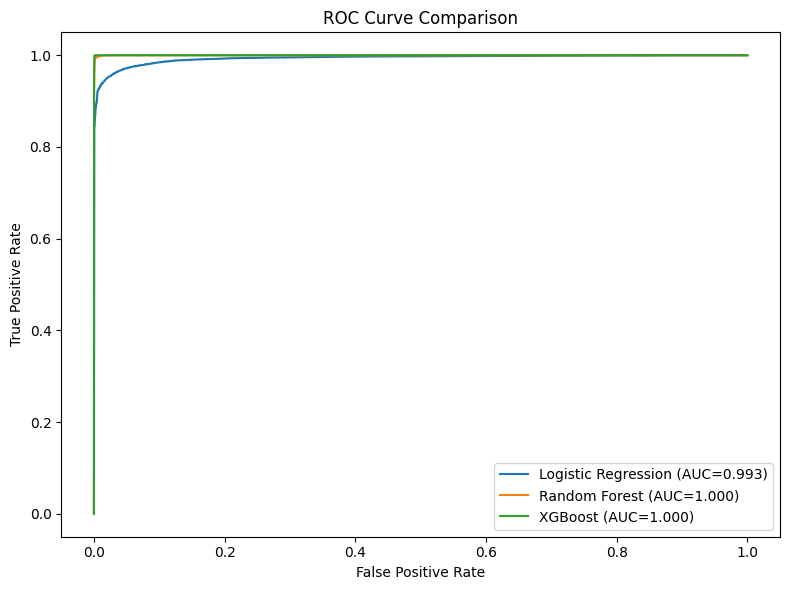

Generating Precision–Recall curves...



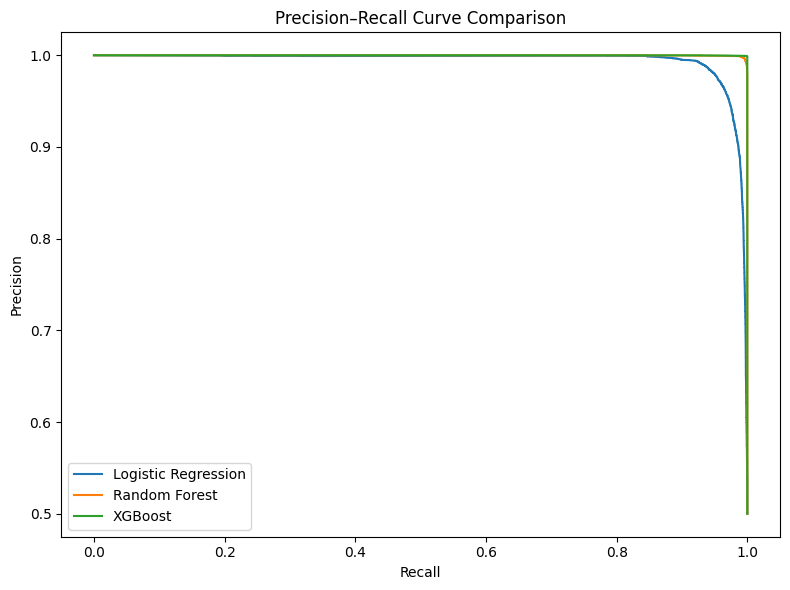

Computing Random Forest feature importance...



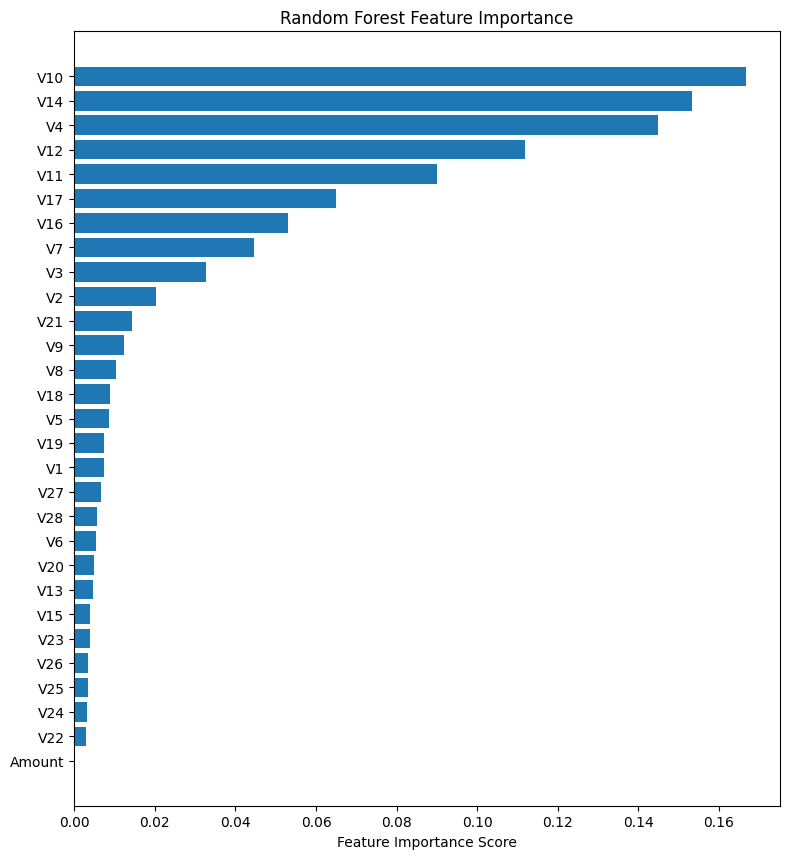

Evaluation complete. All metrics and plots generated.


,Precision,Recall,F1-score,AUC-ROC,Accuracy,R2 Score,RMSE
Logistic Regression,0.976747,0.952939,0.964696,0.993399,0.965127,0.860507,0.186744
Random Forest,0.998793,0.989202,0.993974,0.999884,0.994003,0.976013,0.077439
XGBoost,0.998350,1.000000,0.999174,0.999960,0.999173,0.996694,0.028750


In [39]:
# Imprting the function which generates all evaluations and comparison metrics for models
from evaluation import evaluate_models

results = evaluate_models()
results